In [4]:
!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 113 (delta 43), reused 68 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 18.19 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (43/43), done.


# 1. Loading Dataset

In [5]:
import torch
import torch.utils

from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer



class CirclePathDataset(Dataset):
    def __init__(self, file_path):
        # Load the data from the .pt file
        self.data = torch.load(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the path tensor and the text for the given index
        path_tensor = self.data[idx]['path']
        text = self.data[idx]['text']
        return path_tensor, text


from torch.nn.utils.rnn import pad_sequence
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def collate_fn(batch):
    # Unzip the batch into paths and texts
    paths, texts = zip(*batch)

    # Pad the paths (ensure they're all the same length)
    padded_paths = pad_sequence(paths, batch_first=True, padding_value=0)  # Padding value can be set to 0

    encoded = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    return padded_paths, encoded


# Instantiate the dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")

# Create a DataLoader with the custom collate_fn

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 2. Visualizing Dataset

In [6]:
import torch
import numpy as np

# Assuming you already loaded your dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")

# Containers for analysis
path_lengths = []
positions = []
angles = []
speeds = []

for path, _ in dataset:
    path_lengths.append(path.shape[0])  # Sequence length
    path_np = path.numpy()

    positions.extend(path_np[:, :2])  # x, y
    angles.extend(path_np[:, 2])      # a
    speeds.extend(path_np[:, 3])      # s

positions = np.array(positions)
angles = np.array(angles)
speeds = np.array(speeds)

# Summary stats
print(f"Number of samples: {len(dataset)}")
print(f"Avg. path length: {np.mean(path_lengths):.2f}")
print(f"Max path length: {np.max(path_lengths)}")
print(f"Min path length: {np.min(path_lengths)}")
print(f"Position X: mean={positions[:,0].mean():.2f}, std={positions[:,0].std():.2f}")
print(f"Position Y: mean={positions[:,1].mean():.2f}, std={positions[:,1].std():.2f}")
print(f"Angle (a): mean={angles.mean():.2f}, std={angles.std():.2f}")
print(f"Speed (s): mean={speeds.mean():.2f}, std={speeds.std():.2f}")


Number of samples: 10000
Avg. path length: 40.00
Max path length: 40
Min path length: 40
Position X: mean=500.15, std=83.39
Position Y: mean=500.01, std=83.55
Angle (a): mean=0.95, std=0.22
Speed (s): mean=0.03, std=0.16


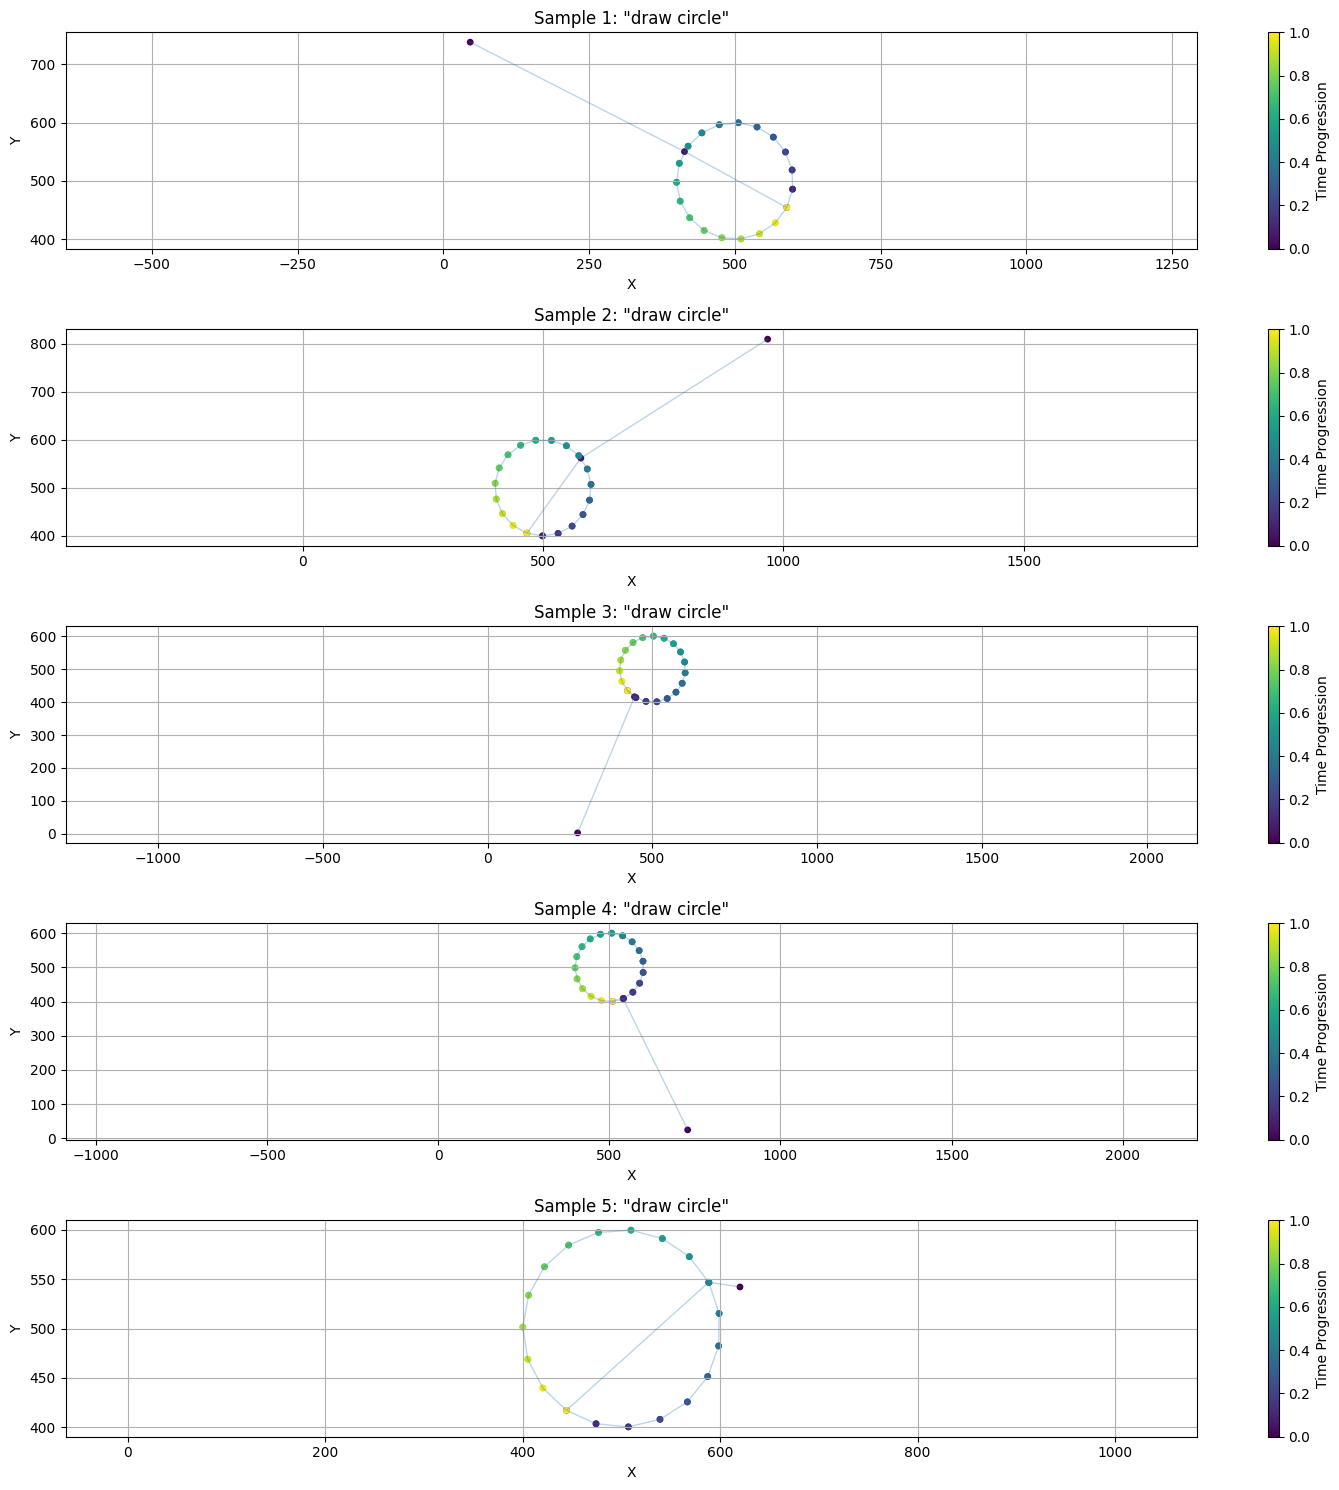

In [7]:
import matplotlib.pyplot as plt

# Visualize a few paths
num_to_plot = 5
plt.figure(figsize=(15, 3 * num_to_plot))

for i in range(num_to_plot):
    path, text = dataset[i]
    path_np = path.numpy()

    x, y = path_np[:, 0], path_np[:, 1]
    time = np.linspace(0, 1, len(x))

    plt.subplot(num_to_plot, 1, i+1)
    scatter = plt.scatter(x, y, c=time, cmap='viridis', s=15)
    plt.plot(x, y, linewidth=1, alpha=0.3)
    plt.title(f"Sample {i+1}: \"{text}\"")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(scatter, label="Time Progression")
    plt.axis("equal")
    plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Training

In [8]:

import torch
from LangPathModel.colab_src.nn import TrajectoryModel
from LangPathModel.colab_src.textEncoders import TextEncoder
from torch.optim.lr_scheduler import StepLR

#data = [Batch, sequence, (batch input, batch target)]

def train(model, dataloader, niter, device):
    criterion = model.get_loss  # assumes it returns CrossEntropyLoss with ignore_index for padding
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    Scheduler = StepLR(optimizer, step_size = 2, gamma=0.2)
    model.positional_encoding = model.positional_encoding.to(device)
    # The model is already defined outside the train function, no need to redefine it here
    # model = TrajectoryModel()
    model.train()
    text_encoder = TextEncoder(output_dim=512)
    text_encoder.to(device) # Move text_encoder to the device

    for epoch in range(niter):
        total_loss = 0
        for batch_paths, batch_texts in dataloader:
            #print(f"paths: {batch_paths[0]}")
            batch_paths = batch_paths.to(device).float()
            #print(type(batch_paths))
            # Shift target for teacher forcing
            decoder_input = batch_paths[:, :-1].to(device)      # all except last token, move to device
            target_output = batch_paths[:, 1:].to(device)        # all except first token, move to device
            encoder_input = batch_paths[:, 0].unsqueeze(1).to(device) # Move encoder_input to the device


            encoder_input_mask = (encoder_input.abs().sum(dim=-1) != 0).int().reshape(-1, 1).to(device) # Move encoder_input_mask to the device
            print(f"encoder_input_mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}"
            emb_text = text_encoder(batch_texts['input_ids'].to(device), batch_texts['attention_mask'].to(device)) # Pass tensors on the device
            text_mask = batch_texts['attention_mask'] == 0

            optimizer.zero_grad()
            #print(f"encoder input mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}")

            emb_text = emb_text.to(device).float()
            text_mask = text_mask.to(device).bool()

            predictions = model(emb_text = emb_text, path = encoder_input, path_mask = encoder_input_mask, tgt = decoder_input, text_mask=text_mask)  # shape: [B, T]
            # Reshape for loss: CrossEntropy wants [B*T, vocab_size] vs [B*T]

            #predictions = predictions.reshape(-1, predictions.size(-1))
            #print("predictions:", predictions.shape)        # should be [32, 199, 512]
            #print("target_output:", target_output.shape)    # should be the same

            loss = criterion(predictions, target_output)#fix this
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(loss.item())

        Scheduler.step()
        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

In [9]:
import torch
import torch.utils

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from LangPathModel.colab_src.nn import TrajectoryModel

from LangPathModel.colab_src.dataset_preprocessing import CirclePathDataset, collate_fn

# Instantiate the dataset
dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle.pt")

# Create a DataLoader with the custom collate_fn
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)

model = TrajectoryModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")


train(model = model, niter = 10, dataloader = dataloader, device = device)
model.to('cpu')
torch.save(model.state_dict(), 'model_state_dict.pth')


Streaming output truncated to the last 5000 lines.
encoder_input_mask: torch.Size([32, 1])
2499.997314453125
encoder_input_mask: torch.Size([32, 1])
2500.060791015625
encoder_input_mask: torch.Size([32, 1])
2500.0078125
encoder_input_mask: torch.Size([32, 1])
2500.03369140625
encoder_input_mask: torch.Size([32, 1])
2500.035400390625
encoder_input_mask: torch.Size([32, 1])
2500.0087890625
encoder_input_mask: torch.Size([32, 1])
2500.0185546875
encoder_input_mask: torch.Size([32, 1])
2500.01611328125
encoder_input_mask: torch.Size([32, 1])
2500.007568359375
encoder_input_mask: torch.Size([32, 1])
2500.028564453125
encoder_input_mask: torch.Size([32, 1])
2500.015625
encoder_input_mask: torch.Size([32, 1])
2500.03564453125
encoder_input_mask: torch.Size([32, 1])
2500.031005859375
encoder_input_mask: torch.Size([32, 1])
2500.011962890625
encoder_input_mask: torch.Size([32, 1])
2500.02294921875
encoder_input_mask: torch.Size([32, 1])
2500.00732421875
encoder_input_mask: torch.Size([32, 1])
2

tensor([[[5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02]]], device='cuda:0')
tensor([[[5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02]]], device='cuda:0')
tensor([[[5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02]]], device='cuda:0')
tensor([[[5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02]]], device='cuda:0')
tensor([[[5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02],
         [5.0002e+02, 5.0000e+02, 9.6528e-01, 1.6951e-02]]], device='cuda:0')
tensor([[[5.0002e+02

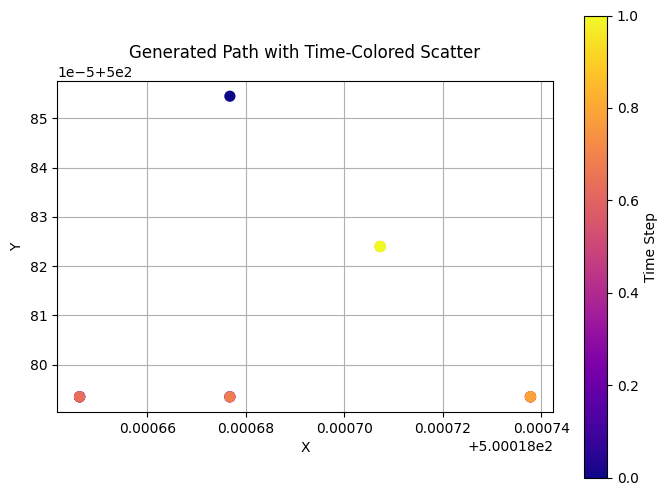

In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from LangPathModel.colab_src.textEncoders import TextEncoder
from transformers import AutoTokenizer

model = TrajectoryModel()  # Use the same args as when saving

# Step 2: Load the saved state dict
model.load_state_dict(torch.load("model_state_dict.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Step 3: Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.positional_encoding = model.positional_encoding.to(device) # This line was added

# Initialize tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = TextEncoder(output_dim=512)


# Text and encoding
text = "Draw circle in the middle"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
txt = text_encoder(encoded['input_ids'], encoded['attention_mask'])

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
txt = txt.to(device)
txt_mask = (encoded['attention_mask'] == 0).to(device)

path_mask = torch.Tensor([[1]]).to(device)

# Iniptialize starting point
start = torch.Tensor([[[100, 100, 0, 0]]]).to(device)  # (1, 1, 4)
tgt = torch.empty([1, 1, 4]).to(device)  # (1, 1, 4)

# Store predictions
positions = []

# Loop to generate 100 predictions
for i in range(20):
    with torch.no_grad():
        prediction = model(
            emb_text=txt,
            path=start,
            tgt=tgt,
            text_mask=txt_mask,
            path_mask=path_mask
        )  # Output shape: (1, seq_len+1, 4
    next_point = prediction[:, -1, :]  # Get the last predicted point
    print(prediction)
    positions.append(next_point[0, :2].cpu().numpy())  # Save (x, y)

    # Append next_point to tgt for next prediction
    tgt = torch.cat([tgt, next_point.unsqueeze(1)], dim=1)

# Convert to numpy array
positions = np.array(positions)  # shape: (num_points, 2)
colors = np.linspace(0, 1, len(positions))  # Normalized color values for time

# Scatter plot with color based on time
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], c=colors, cmap='plasma', s=50)
plt.colorbar(label="Time Step")
plt.title("Generated Path with Time-Colored Scatter")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

